In [1]:
using NBInclude
@nbinclude("Hofstadter Single Particle in Julia.ipynb")

Hofstadter_SP (generic function with 1 method)

In [2]:
using QuantumOptics

In [3]:
function Hofstadter_SP_QoJulia(Nx, Ny, alpha)
    
    global N = Nx*Ny
    
    global Basis = NLevelBasis(N)
    
    H = SparseOperator(Basis)

    for m in 1:N
        for n in 1:N
            H = H + Hofstadter_SP(Nx,Ny,alpha)[m,n] * transition(Basis, m, n)
        end
    end
    
    return H
end

Hofstadter_SP_QoJulia (generic function with 1 method)

1) Hofstadter SP QoJulia energies are has to be equal to Hofstadter Single Particle energies.

In [18]:
eigenenergies(dense(Hofstadter_SP_QoJulia(4, 4, 1/4)))

16-element Vector{Float64}:
 -2.8284271247461907
 -2.8284271247461903
 -2.8284271247461903
 -2.82842712474619
 -1.1167677465403345e-15
 -7.132824257228577e-16
 -3.5568195276418255e-16
 -2.891569699351327e-17
  3.44562773482353e-16
  7.419053630765259e-16
  8.411867529740632e-16
  1.730837487209917e-15
  2.828427124746188
  2.828427124746189
  2.828427124746191
  2.828427124746191

In [5]:
using LinearAlgebra
eigen(Hofstadter_SP(4,4,1/4))

Eigen{ComplexF64, Float64, Matrix{ComplexF64}, Vector{Float64}}
values:
16-element Vector{Float64}:
 -2.8284271247461903
 -2.8284271247461903
 -2.8284271247461885
 -2.828427124746186
 -9.842582652396219e-17
 -5.2371492063649606e-17
  1.1952921159963832e-16
  3.920905899911496e-16
  3.1086244689504383e-15
  3.552713678800501e-15
  3.9968028886505635e-15
  4.884981308350689e-15
  2.8284271247461894
  2.8284271247461894
  2.82842712474619
  2.8284271247461903
vectors:
16×16 Matrix{ComplexF64}:
  -0.184749+0.257583im    …        0.125-0.125im
  0.0257639+0.166806im               0.0+0.0im
   0.111495+0.0319115im           -0.125-0.125im
  -0.105686-0.00238628im     6.49467e-17+0.353553im
  -0.305909+0.347793im               0.0+0.0im
  -0.239274+0.185898im    …          0.0+0.0im
  -0.282235+0.102805im               0.0+0.0im
  -0.296244+0.225671im             -0.25+3.08149e-33im
  -0.144976+0.314553im             0.125+0.125im
 -0.0494383+0.0781814im              0.0+0.0im
   0.151268+0.0

## Single-Particle Subspace Hofstadter for Finite-U

In [7]:
function Sub_Space_Hofstadter_Finite_U(SP_O, N_cut, PN, U)
    
    # Sp initial States band subspace
    E0, states0 = eigenstates(dense(SP_O))
    states = states0[1:N_cut]

    # SubspaceBasis( SP Basis, Restricted States)
    b_sub = SubspaceBasis(Basis,states)
    
    # projector( Subspace Basis, SP Basis )
    P = projector(b_sub, Basis)
    Pt = dagger(P)
    
    O_sub = P*SP_O*Pt
    
    StatesBH = bosonstates(b_sub, [PN]) 
    Basis_MB = ManyBodyBasis(b_sub, StatesBH)

    NM_MB_Array_Storage = zeros(Complex{Float64},length(Basis_MB),length(Basis_MB),N)
    NM_MB_Matrix = zeros(Complex{Float64},length(Basis_MB),length(Basis_MB))

    # projecting number operator to the regarding to subspace 
    IT = SparseOperator(Basis_MB)

    for m in 1:N
        NM = transition(Basis, m, m)
        NMP = P*NM*Pt

        # Auto (slower)
        #NM_MB_1 = manybodyoperator(Basis_MB, NMP)

        # Manuel (faster)
        NM_MB_2 = SparseOperator(Basis_MB)
        for i in 1:length(b_sub)
            for j in 1:length(b_sub)
                NM_MB_2 = NM_MB_2 + NMP.data[i,j] * transition(Basis_MB, i, j)
            end
        end
        # NM_MB_1 == NM_MB_2 (true)

        # Convert NM_MB operator into the NM_MB_Matrix matrix to storage all of NM_MB operator according to each m index
        for i in 1:length(Basis_MB)
            for j in 1:length(Basis_MB)
                NM_MB_Matrix[i,j] = NM_MB_2.data[i,j]
            end
        end
        NM_MB_Array_Storage[:,:,m] = NM_MB_Matrix
        # end

        IT = IT + U/2 * NM_MB_2 * ( NM_MB_2 - identityoperator(Basis_MB) )
    end
    
    KT = SparseOperator(Basis_MB)
    for m in 1:length(b_sub)
        for n in 1:length(b_sub)
            KT = KT + O_sub.data[m,n] * transition(Basis_MB, m, n)
        end
    end
    
    return H = KT + IT
end

Sub_Space_Hofstadter_Finite_U (generic function with 1 method)

2) If U<<Band-Gap, Sub-Space Hofstadter Finite-U energies converges at Hofstadter Finite-U energies.
3) When all SP states projected to the new sub-space, Sub-Space Hofstadter Finite-U energies have to equal to Hofstadter Finite-U energies.

In [12]:
@nbinclude("Hofstadter MB in Julia.ipynb"; renumber=true, regex=r"#.*executeme")

Hofstadter_Finite_U (generic function with 1 method)

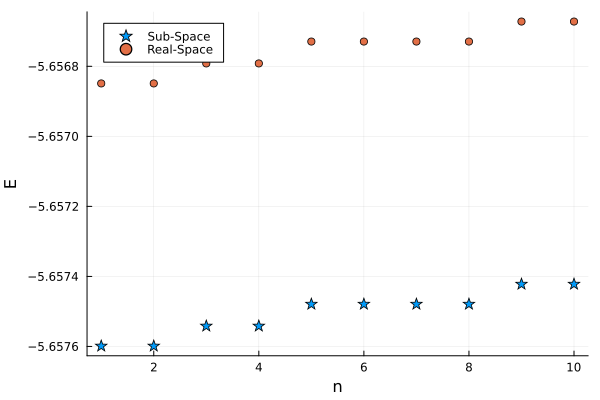

In [21]:
using Plots

x = Sub_Space_Hofstadter_Finite_U(Hofstadter_SP_QoJulia(4, 4, 1/4), 4, 2, 1/1000)
E1 = eigenenergies(dense((x+dagger(x))/2)) 

E2 = eigenenergies(dense(Hofstadter_Finite_U(4, 4, 1/4, 2, 1/1000)))[1:length(E1)]

plot(1:length(E1),E1,seriestype=:scatter,markershape=:star5, markersize=6, label="Sub-Space")
plot!(1:length(E2),E2,seriestype=:scatter,label="Real-Space",legend=:topleft)

xlabel!("n");ylabel!("E")